# Individual Position Dataset

# Data Preparation

## Install packages and libraries

In [4]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn


## Importing necessary libraries

In [5]:
import datetime
import os

import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D

%matplotlib inline


## Pre-processing

### Definining the relative directory path and concatenation of all dataframes

In [6]:
relative_path = '../datasets/individual_position'
folder_path = os.path.join(os.getcwd(), relative_path)
dataframes = []

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)

    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        dataframes.append(df)

df_ind_position = pd.concat(dataframes, ignore_index=True)


### Convert columns to Datetime

In [7]:
df_ind_position['startdate'] = pd.to_datetime(df_ind_position['startdate'])
df_ind_position['enddate'] = pd.to_datetime(df_ind_position['enddate'])

df_ind_position = df_ind_position[df_ind_position != 'empty'].dropna()
df_ind_position = df_ind_position.dropna(subset=['enddate'])

### Setting the function to filter companies

In [8]:
companies = [
    'Microsoft Corp.',
    'Amazon.com, Inc.',
    'Apple, Inc.',
    'Meta Platforms, Inc.',
    'Intel Corp.',
    'Netflix, Inc.',
    'Oracle Corp.',
    'Cisco Systems, Inc.',
    'SAP SE',
    'Samsung Electronics Co., Ltd.'
]

df_big_tech = df_ind_position[df_ind_position['company_name'].isin(companies)]
df_big_tech = df_big_tech[df_big_tech['ultimate_parent_company_name'].isin(companies)]


# Job Tenures Analysis

## Preparation and analysis of employee tenure duration (2016-01 onwards) 

In [9]:
df_big_tech['duration'] = (df_big_tech['enddate'] - df_big_tech['startdate']).dt.days
df_big_tech = df_big_tech[df_big_tech['duration'] > 0]
duration_stats = df_big_tech['duration'].describe()
print("Duration Statistics for Big Tech Companies:\n", duration_stats)


Duration Statistics for Big Tech Companies:
 count    389392.000000
mean        558.206804
std         421.223939
min          28.000000
25%         242.000000
50%         457.000000
75%         762.000000
max        2800.000000
Name: duration, dtype: float64


## Analysis of median duration and roles with job tenures shorter than median

In [10]:
median_duration = df_big_tech['duration'].median()
print("Median Duration of Job Tenure:\n", median_duration)

short_duration_threshold = median_duration  # Define the threshold
short_duration_positions = df_big_tech[df_big_tech['duration'] < short_duration_threshold]
grouped_analysis = short_duration_positions.groupby(['company_name', 'role_k150'])['duration'].median()
shorter_than_median = df_big_tech[df_big_tech['duration'] < median_duration]
time_analysis = shorter_than_median['startdate'].dt.to_period("M").value_counts().sort_index()
role_analysis = shorter_than_median['role_k150'].value_counts()
top_roles = shorter_than_median['role_k150'].value_counts().nlargest(10)
print("Count of Top 10 Roles with Job Tenures Shorter than Median:\n", top_roles)


Median Duration of Job Tenure:
 457.0
Count of Top 10 Roles with Job Tenures Shorter than Median:
 role_k150
Software Engineer             32935
Distribution Specialist        7534
Logistics                      5148
Driver                         5114
Data Scientist                 4998
Scientist                      4005
Marketing                      3882
Operations Coordinator         3525
Human Resources Specialist     3382
Recruiter                      3315
Name: count, dtype: int64


## Creating pivot table to examine the frequency of top 10 roles with job tenures shorter than median

In [11]:
shorter_than_median['period'] = shorter_than_median['startdate'].dt.to_period("M")
top_roles = shorter_than_median['role_k150'].value_counts().nlargest(10).index
top_roles_data = shorter_than_median[shorter_than_median['role_k150'].isin(top_roles)]

# Create a pivot table
pivot_table_top_roles = pd.pivot_table(top_roles_data, 
                                       values='duration', 
                                       index='period', 
                                       columns='role_k150', 
                                       aggfunc='count', 
                                       fill_value=0)

# Reindex the columns to include only the top 10 categories
pivot_table_top_roles = pivot_table_top_roles.reindex(columns=top_roles)


/var/folders/_t/rmxszd9j67bbhb9px38fchl40000gn/T/ipykernel_70910/2746948314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shorter_than_median['period'] = shorter_than_median['startdate'].dt.to_period("M")


### Plotting job tenure time series to analyze trends and patterns

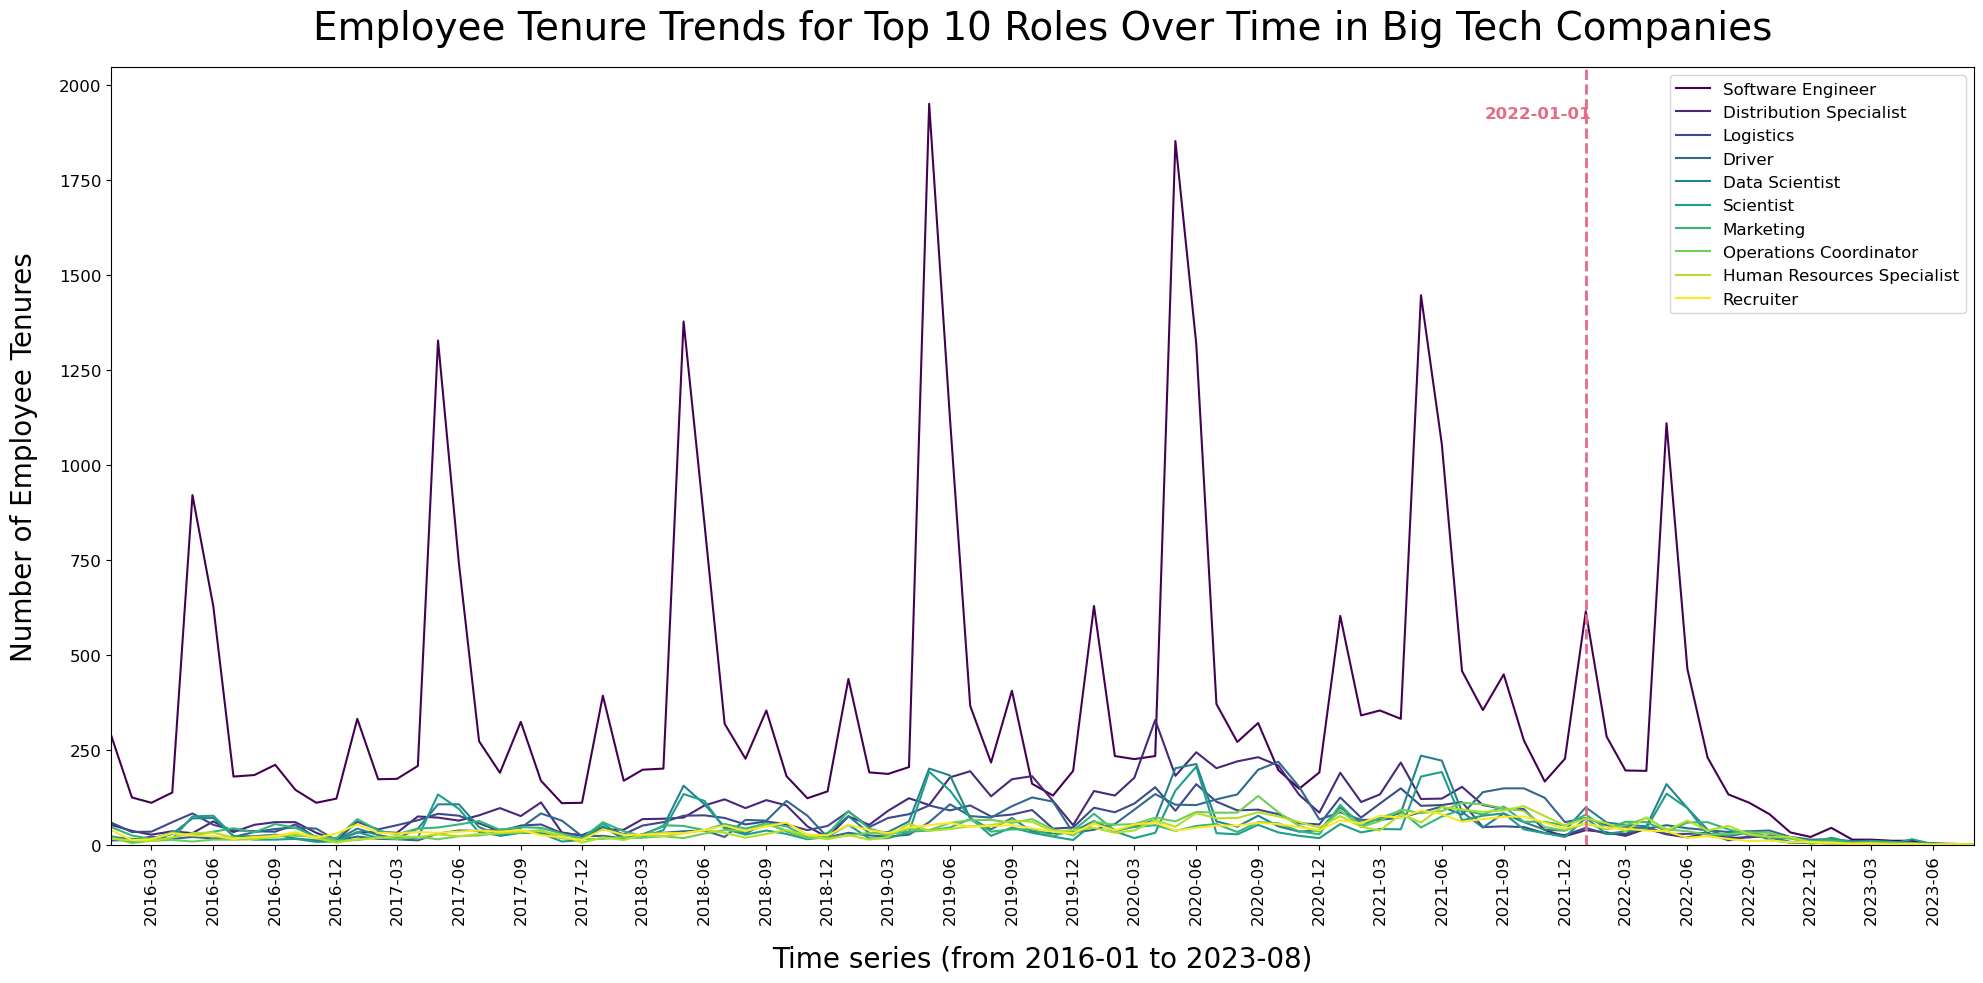

In [12]:
plt.rcParams.update({'font.size': 12})
top_roles = pivot_table_top_roles.sum().nlargest(10).index
colors = plt.cm.viridis(np.linspace(0, 1, len(top_roles)))  # Using a colormap suitable for 10 items
fig, ax = plt.subplots(figsize=(20, 10))
for index, role in enumerate(top_roles):
    data = pivot_table_top_roles[role]
    timestamps = pivot_table_top_roles.index.to_timestamp()
    ax.plot(timestamps, data, label=role, color=colors[index], linewidth=1.5)

time_start = timestamps.min().strftime('%Y-%m')
time_end = timestamps.max().strftime('%Y-%m')
ax.set_title('Employee Tenure Trends for Top 10 Roles Over Time in Big Tech Companies', fontsize=28, pad=20)
ax.set_xlabel(f'Time series (from {time_start} to {time_end})', fontsize=20, labelpad=15)
ax.set_ylabel('Number of Employee Tenures', fontsize=20, labelpad=15)

ax.legend(fontsize=12, loc='upper right')
ax.set_xlim([timestamps.min(), timestamps.max()])
ax.set_ylim(bottom=0)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
significant_date = datetime.datetime(2022, 1, 1)
ax.axvline(significant_date, color=(231/255, 106/255, 135/255), linestyle='--', linewidth=2)
label_offset_x = 150  # Number of days to offset label to the left
label_offset_y = 0.05  # Proportion of the y-axis range to offset label down
label_position_x = significant_date - datetime.timedelta(days=label_offset_x)  # Shift label to the left
label_position_y = ax.get_ylim()[1] * (1 - label_offset_y)  # Shift label down
ax.text(label_position_x, label_position_y, f"{significant_date.strftime('%Y-%m-%d')}",
        verticalalignment='top', horizontalalignment='left',
        color=(231/255, 106/255, 135/255), fontsize=12,  fontweight='bold')

plt.grid(False)
plt.show()


# Focusing on big tech companies in the interval 2022-01 to early (April) 2023

## Patterns in Grouped Analysis

In [13]:
# Applying date filter
df_int = df_big_tech[(df_big_tech['startdate'] >= '2022-01-01') & (df_big_tech['enddate'] <= '2023-04-30')]

In [14]:
median_duration = df_int['duration'].median()
print("Median Duration of Job Tenure in the Relevant Time Interval:\n", median_duration)

shorter_than_median = df_int[df_int['duration'] < median_duration]
top_roles = shorter_than_median['role_k150'].value_counts().head(10)
print("Count of Top 10 Roles with Job Tenures Shorter than Median in the Relevant Time Interval:\n", top_roles)


Median Duration of Job Tenure in the Relevant Time Interval:
 153.0
Count of Top 10 Roles with Job Tenures Shorter than Median in the Relevant Time Interval:
 role_k150
Software Engineer     2248
Student Intern         617
Crew Member            324
Data Scientist         321
Scientist              295
Corporate Trainer      267
Software Developer     265
Driver                 214
Producer               200
Cashier                190
Name: count, dtype: int64


### Plotting % of shorter than median job tenures across top 10 company

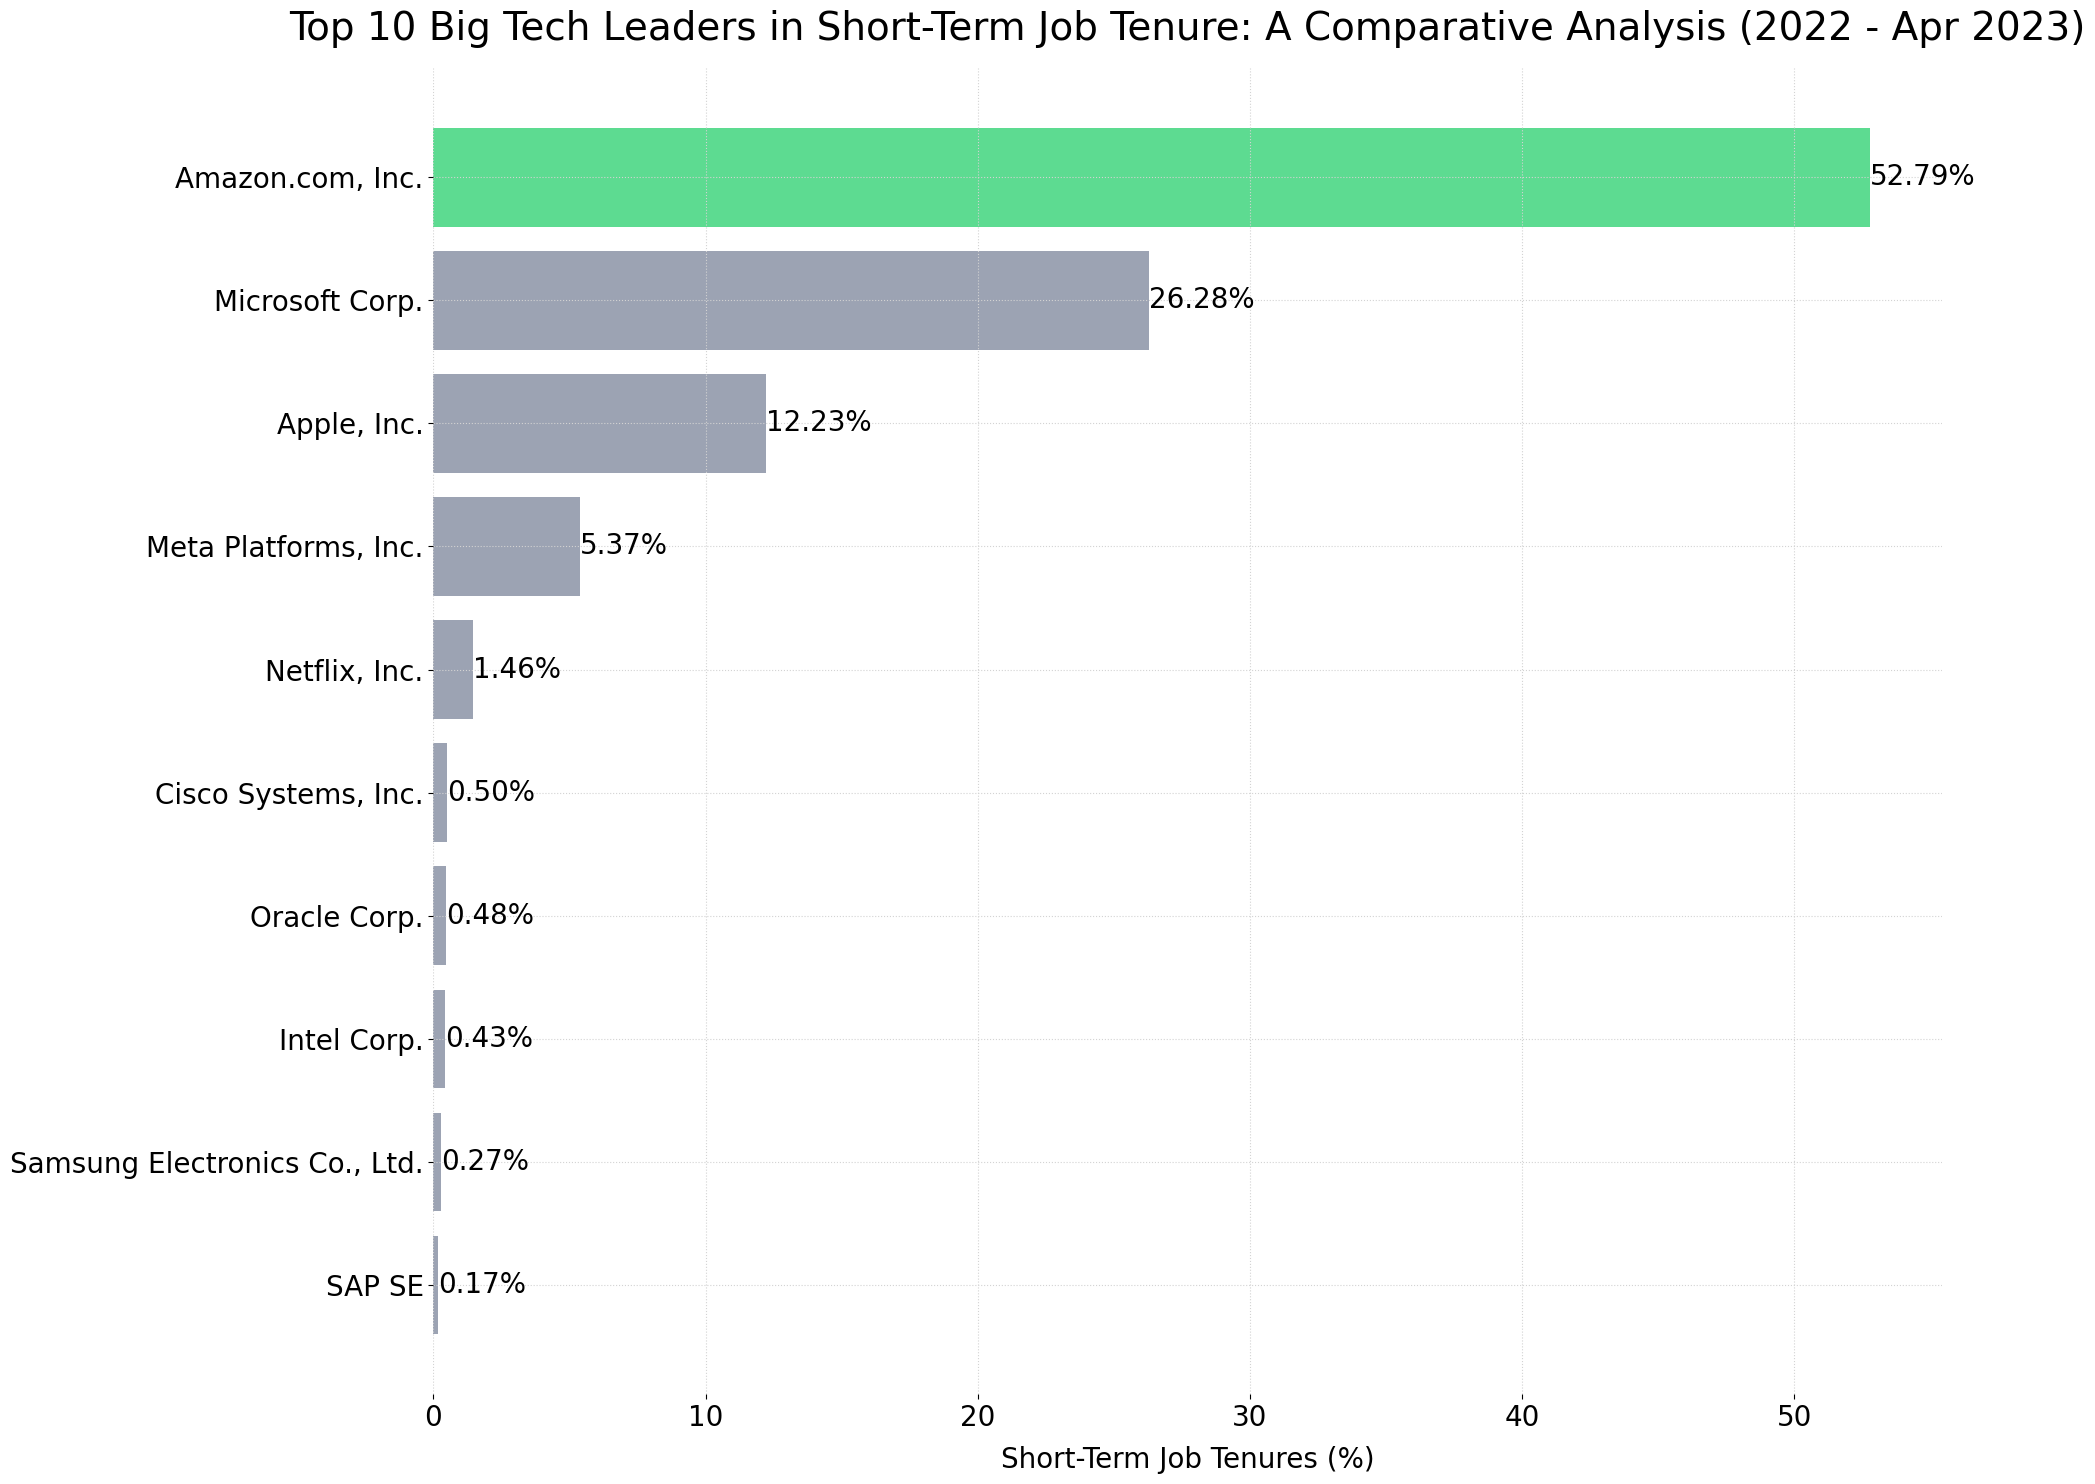

In [15]:
grouped_data = shorter_than_median.groupby('company_name').size().reset_index(name='count')
total_short_duration_jobs = grouped_data['count'].sum()
grouped_data['percentage'] = (grouped_data['count'] / total_short_duration_jobs) * 100
sorted_grouped_data = grouped_data.sort_values(by='percentage', ascending=True).head(10)
colors = [(156/255, 163/255, 179/255)] * 9 + [(93/255, 219/255, 145/255)]

plt.figure(figsize=(20, 15))
plt.barh(sorted_grouped_data['company_name'], sorted_grouped_data['percentage'], color=colors)
plt.title('Top 10 Big Tech Leaders in Short-Term Job Tenure: A Comparative Analysis (2022 - Apr 2023)', fontsize=28, pad=20)
plt.xlabel('Short-Term Job Tenures (%)', fontsize=20, labelpad=10)         
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.box(False)  # Remove the border
plt.grid(True, linestyle=':', color='lightgrey')

for index, value in enumerate(sorted_grouped_data['percentage']):
    plt.text(value, index, f'{value:.2f}%', va='center', fontsize=20)

plt.tight_layout()
plt.show()


### Top 5 job roles for each company with the highest count of short-term job tenure

In [16]:
grouped_jobs = shorter_than_median.groupby(['company_name', 'role_k150']).size().reset_index(name='count')
top_5_jobs_per_company = grouped_jobs.groupby('company_name').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

print("Top 5 Short-Term Job Tenures for Each Company:\n")
print(top_5_jobs_per_company)


Top 5 Short-Term Job Tenures for Each Company:

                     company_name                    role_k150  count
0                Amazon.com, Inc.            Software Engineer    934
1                Amazon.com, Inc.               Student Intern    314
2                Amazon.com, Inc.                  Crew Member    254
3                Amazon.com, Inc.                       Driver    203
4                Amazon.com, Inc.                      Cashier    155
5                     Apple, Inc.            Software Engineer    132
6                     Apple, Inc.                       Genius     64
7                     Apple, Inc.               Student Intern     57
8                     Apple, Inc.                     Producer     51
9                     Apple, Inc.                Test Engineer     50
10            Cisco Systems, Inc.            Software Engineer     19
11            Cisco Systems, Inc.               Student Intern      4
12            Cisco Systems, Inc.  Custome

#### Plotting % of top 5 short-term job tenures at Amazon.com, Inc. (2022 - Apr 2023)

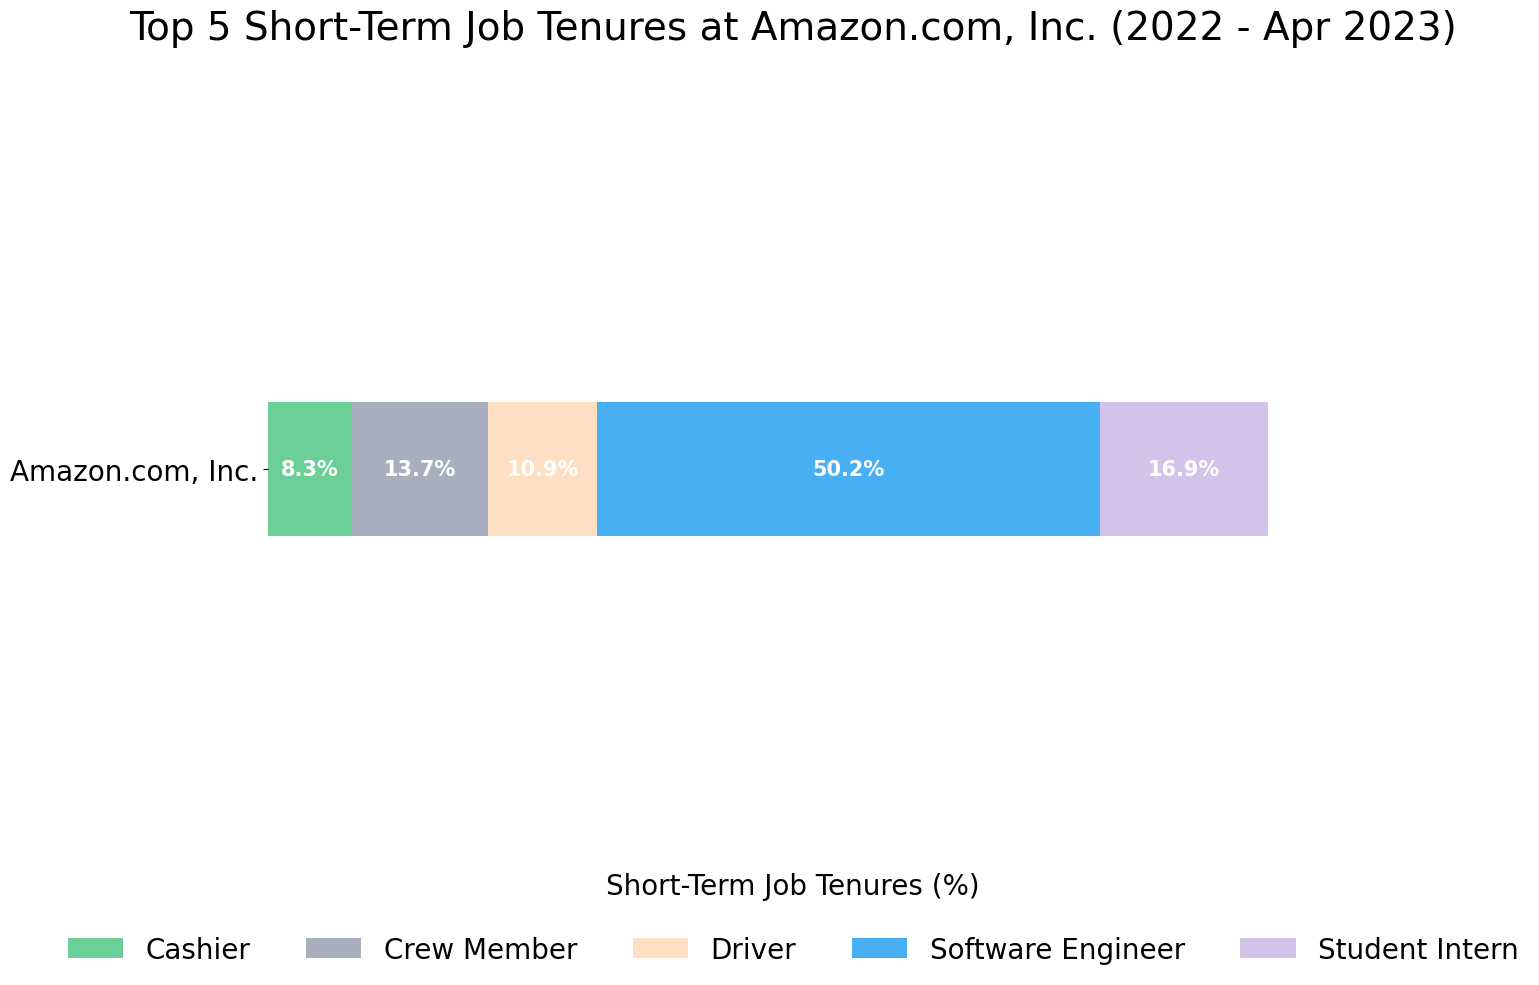

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

company_to_keep = ['Amazon.com, Inc.']
filtered_data = top_5_jobs_per_company[top_5_jobs_per_company['company_name'].isin(company_to_keep)]
pivoted_data = filtered_data.pivot(index='company_name', columns='role_k150', values='count').fillna(0)
pivoted_data['Total'] = pivoted_data.sum(axis=1)

for column in pivoted_data.columns:
    if column != 'Total':
        pivoted_data[column] = (pivoted_data[column] / pivoted_data['Total']) * 100

pivoted_data.drop(columns='Total', inplace=True)
color_map = [(108/255, 207/255, 152/255),
             (168/255, 174/255, 190/255),
             (253/255, 224/255, 196/255), 
             (72/255, 175/255, 244/255),
             (210/255, 195/255, 233/255)]

# Decrease the width parameter to make bars less thick
ax = pivoted_data.plot(kind='barh', stacked=True, color=color_map, figsize=(15, 10), width=0.1)
plt.title('Top 5 Short-Term Job Tenures at Amazon.com, Inc. (2022 - Apr 2023)', fontsize=28, pad=20)
plt.xlabel('Short-Term Job Tenures (%)', fontsize=20, labelpad=1)  # Reduced labelpad
plt.xticks(ticks=[], labels=[])  # Remove the x-axis numeric labels but keep the axis
plt.yticks(range(len(pivoted_data.index)), pivoted_data.index, fontsize=20)
ax.legend(title='', loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=len(pivoted_data.columns), frameon=False, fontsize=20)  # Adjusted legend position
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylabel('')  # Removes the 'company_name' label

# Adding percentage values at the center of each block
for n, bar in enumerate(ax.patches):
    width = bar.get_width()
    y = bar.get_y()
    height = bar.get_height()
    value = pivoted_data.iloc[n // len(color_map), n % len(color_map)]
    if width > 0:  # Ensure there's enough room to place text
        ax.text(width/2 + bar.get_x(), y + height/2, f"{value:.1f}%", ha='center', va='center', color='white', weight='bold', fontsize=15)

plt.tight_layout()
plt.show()


# Salary Analysis

## Median salary and Salary Comparison 

In [18]:
# Calculate the median salary
overall_median_salary = df_int['salary'].median()
print(f"Overall Median Salary: {overall_median_salary}")

# Group by company and calculate the median salary for each company
median_salary_by_company = df_int.groupby('company_name')['salary'].median()
sorted_median_salary_by_company = median_salary_by_company.sort_values(ascending=False)

# Calculate the salary range as the difference between max and min salaries
salary_range_by_company = df_int.groupby('company_name')['salary'].agg(['min', 'max'])
salary_range_by_company['salary_range'] = salary_range_by_company['max'] - salary_range_by_company['min']

print("\nMedian Salary by Company:")
print(sorted_median_salary_by_company)

# Making a comparison and sorting the results
print("\nSalary Comparison with Overall Median (Sorted):")
salary_comparison_sorted = sorted_median_salary_by_company.apply(lambda x: "Above" if x > overall_median_salary else "Below" if x < overall_median_salary else "Equal")
print(salary_comparison_sorted)

# Display the salary range for each company
print("Salary Range for Each Company:")
print(salary_range_by_company[['salary_range']])

Overall Median Salary: 73678.741262

Median Salary by Company:
company_name
Apple, Inc.                      88836.165880
Meta Platforms, Inc.             84420.408583
Microsoft Corp.                  79467.240383
Intel Corp.                      77480.140569
Amazon.com, Inc.                 64445.297336
Cisco Systems, Inc.              64010.004130
Netflix, Inc.                    63118.186512
SAP SE                           52396.359539
Oracle Corp.                     47461.628496
Samsung Electronics Co., Ltd.    23444.986520
Name: salary, dtype: float64

Salary Comparison with Overall Median (Sorted):
company_name
Apple, Inc.                      Above
Meta Platforms, Inc.             Above
Microsoft Corp.                  Above
Intel Corp.                      Above
Amazon.com, Inc.                 Below
Cisco Systems, Inc.              Below
Netflix, Inc.                    Below
SAP SE                           Below
Oracle Corp.                     Below
Samsung Electronics Co

In [19]:
# Calculate the quartiles of the salary column
quartiles = df_int['salary'].quantile([0.25, 0.5, 0.75])

print("Salary Distribution Quartiles:")
print(quartiles)


Salary Distribution Quartiles:
0.25     37933.948996
0.50     73678.741262
0.75    106770.520836
Name: salary, dtype: float64


## Plotting Median Salary and Salary Range for top 10 Big Tech Company

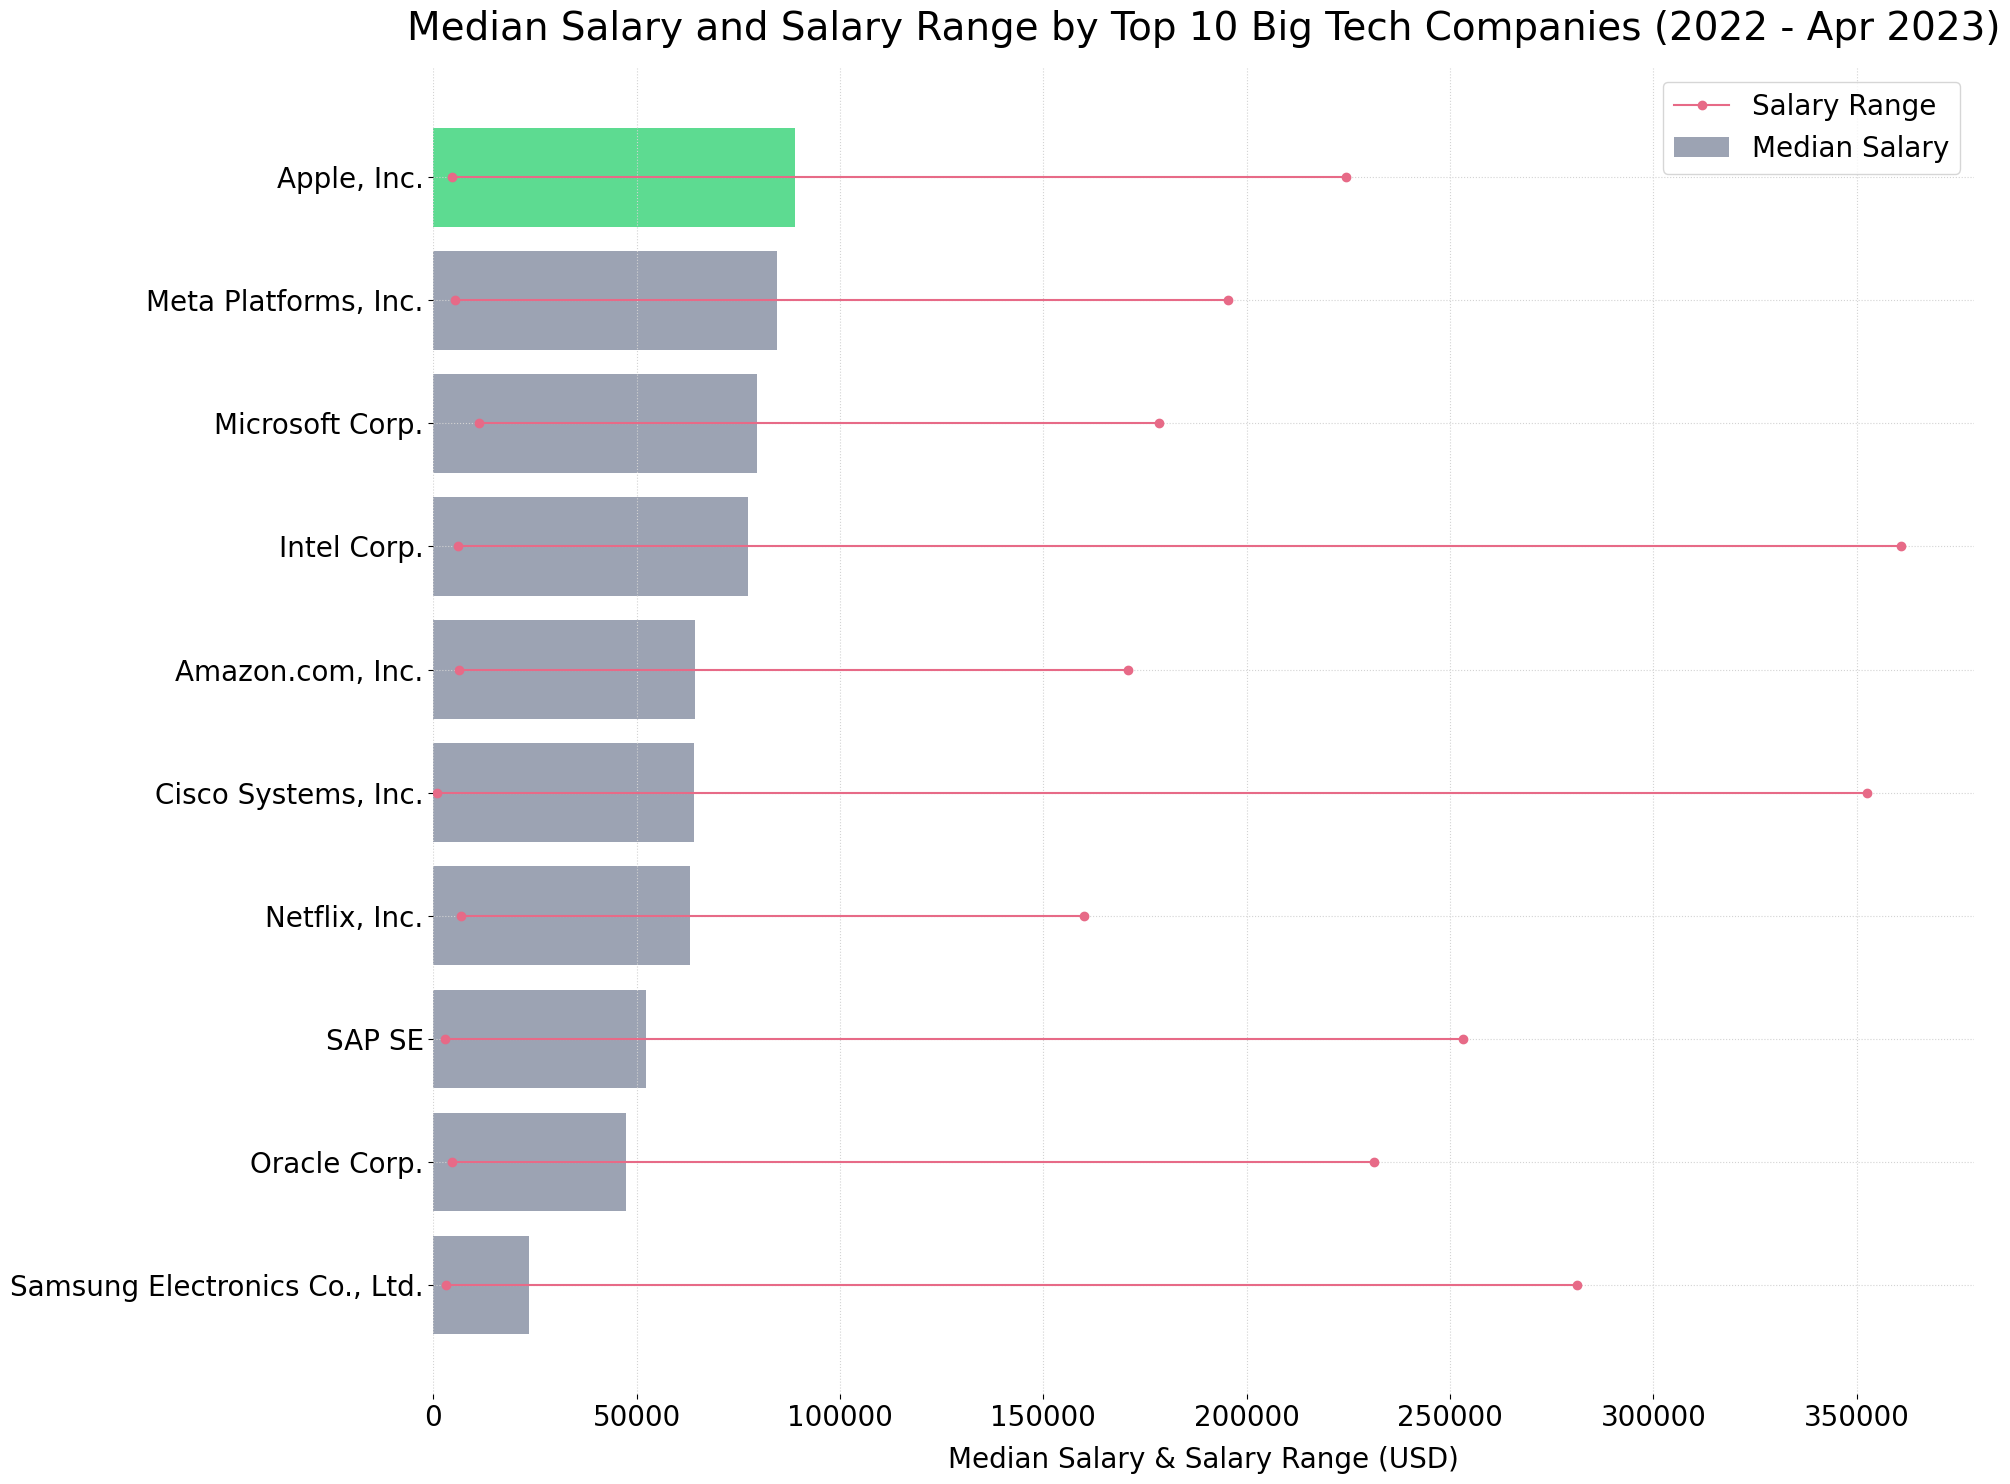

In [20]:
companies = sorted_median_salary_by_company.index[::-1]
median_salaries = sorted_median_salary_by_company.values[::-1]
salary_ranges = salary_range_by_company.loc[companies, 'salary_range']

plt.figure(figsize=(20, 15))
colors = [(156/255, 163/255, 179/255) for _ in companies]
colors[-1] = (93/255, 219/255, 145/255)

bar_plot = plt.barh(companies, median_salaries, color=colors, label='Median Salary')
salary_range_color = (231/255, 106/255, 135/255)
for i, company in enumerate(companies):
    min_salary = salary_range_by_company.loc[company, 'min']
    max_salary = salary_range_by_company.loc[company, 'max']
    plt.plot([min_salary, max_salary], [len(companies) - 1 - i, len(companies) - 1 - i], color=salary_range_color, marker='o', label='Salary Range' if i == 0 else "")

range_handle = mpatches.Patch(color=salary_range_color, label='Salary Range')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize=20)

plt.xlabel('Median Salary & Salary Range (USD)', fontsize=20, labelpad=10)
plt.ylabel('', fontsize=20, labelpad=10)
plt.title('Median Salary and Salary Range by Top 10 Big Tech Companies (2022 - Apr 2023)', fontsize=28, pad=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.box(False)  # Remove the border
plt.grid(True, linestyle=':', color='lightgrey')

plt.tight_layout()
plt.show()


### Plotting Median Salary and Percentage of Short-Term Job Tenures in each of the top 10 Big Tech Companies 

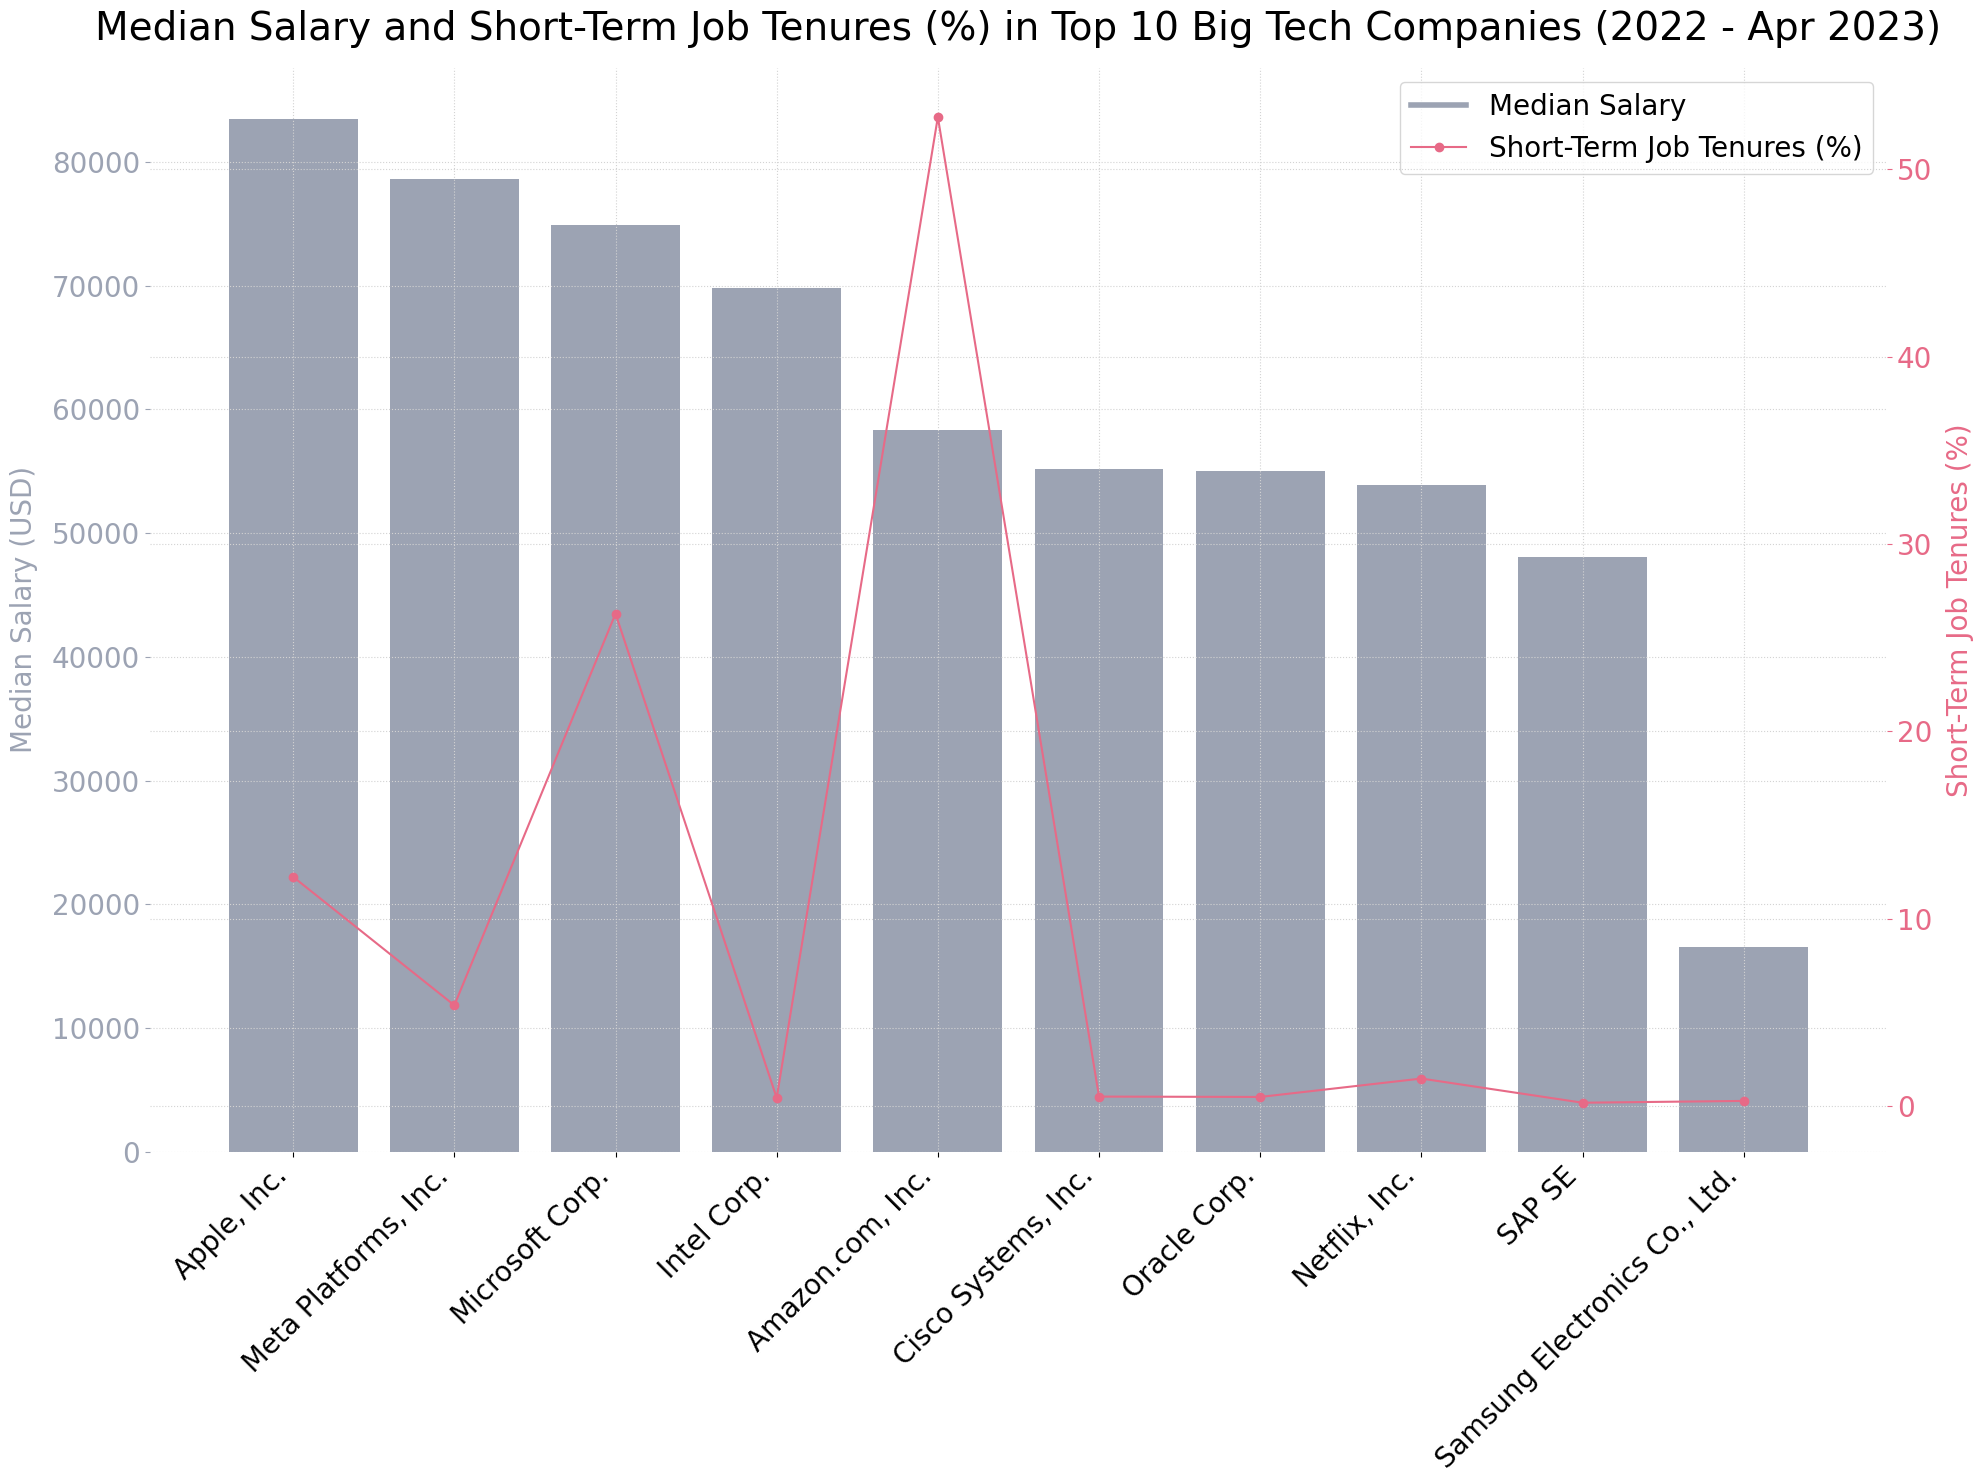

In [21]:
grouped_data = shorter_than_median.groupby('company_name').agg({
    'salary': 'median',      # Median salary
    'duration': 'size'       # Count of positions shorter than median duration
}).reset_index()

total_short_duration_jobs = grouped_data['duration'].sum()
grouped_data['percentage'] = (grouped_data['duration'] / total_short_duration_jobs) * 100
sorted_grouped_data = grouped_data.sort_values(by='salary', ascending=False)

bar_color = (156/255, 163/255, 179/255)
line_color = (231/255, 106/255, 135/255)

fig, ax1 = plt.subplots(figsize=(20, 15))
salary_bars = ax1.bar(sorted_grouped_data['company_name'], sorted_grouped_data['salary'], color=bar_color)

ax1.set_ylabel('Median Salary (USD)', color=bar_color, fontsize=20, labelpad=10)
ax1.tick_params('y', colors=bar_color, labelsize=20)

ax2 = ax1.twinx()
percentage_line, = ax2.plot(sorted_grouped_data['company_name'], sorted_grouped_data['percentage'], color=line_color, marker='o')
ax2.set_ylabel('Short-Term Job Tenures (%)', color=line_color, fontsize=20, labelpad=10)
ax2.tick_params('y', colors=line_color, labelsize=20)

ax1.set_xticks(range(len(sorted_grouped_data['company_name'])))
ax1.set_xticklabels(sorted_grouped_data['company_name'], rotation=45, ha='right', fontsize=20)

salary_handle = Line2D([0], [0], color=bar_color, lw=4, label='Median Salary')
percentage_handle = Line2D([0], [0], color=line_color, marker='o', label='Short-Term Job Tenures (%)')
ax1.legend(handles=[salary_handle, percentage_handle], loc='best', fontsize=20)

plt.title('Median Salary and Short-Term Job Tenures (%) in Top 10 Big Tech Companies (2022 - Apr 2023)', fontsize=28, pad=20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.grid(True, linestyle=':', color='lightgrey')
ax2.grid(True, linestyle=':', color='lightgrey')

plt.tight_layout()
plt.show()
